In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

In [24]:
X = pd.read_csv('./data/x_train.txt', sep = ' ', header = None)
y = pd.read_csv('./data/y_train.txt', header = None)
scaler = StandardScaler()

In [162]:
def predict(proba, count):
    '''proba - probabilities, 2d array where first column is probabilities of 0, second is probabilities of 1 - typical .predict_proba() output of sklearn classifiers
    count - int, how many 1's we want to get
    
    returns array of predictions with `count` 1's '''
    proba_1 = proba[:,1]
    ids = np.argsort(proba_1)[-count:]
    pred = np.zeros(proba.shape[0])
    pred[ids] = 1
    return pred.astype(int)

# analiza wstępna:

In [61]:
df = deepcopy(X)
df['target'] = y
corr_matrix = df.corr()
target_corr = corr_matrix['target']
target_corr = abs(target_corr)
target_corr.sort_values(ascending = False, inplace = True)

403    0.045464
323    0.040858
285    0.040197
220    0.039703
155    0.039277
         ...   
93     0.000092
493    0.000078
134    0.000051
389    0.000045
483    0.000012
Name: target, Length: 500, dtype: float64

<BarContainer object of 500 artists>

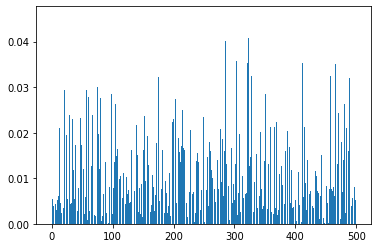

In [62]:
target_corr = target_corr[1:]
plt.bar(target_corr.index, target_corr)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mipec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

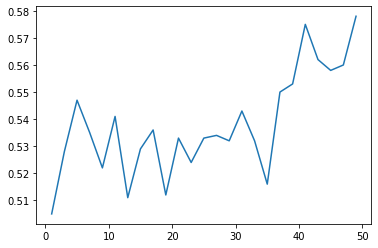

In [68]:
anova_accs = []
feature_counts = np.arange(1, 50, 2)
for number_of_features in feature_counts:
    fvalue_selector = SelectKBest(f_classif, k=number_of_features)
    X_kbest = fvalue_selector.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size = 0.2, stratify=y)
    
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train[0])
    anova_accs.append(accuracy_score(y_test, clf.predict(X_test)))
plt.plot(feature_counts, anova_accs)

In [69]:
corr_accs = []
feature_counts = np.arange(1, 50, 2)
for number_of_features in feature_counts:
    X_kbest = X[target_corr[:number_of_features].index]
    X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size = 0.2, stratify=y)
    
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train[0])
    corr_accs.append(accuracy_score(y_test, clf.predict(X_test)))

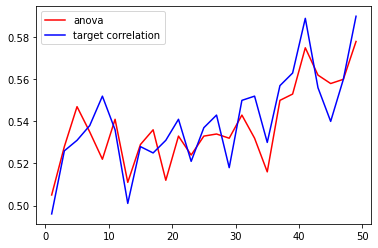

In [152]:
plt.plot(feature_counts, anova_accs, c = 'red', label = 'anova')
plt.plot(feature_counts, corr_accs, c = 'blue', label = 'target correlation')
plt.legend()

In [ ]:
def get_features_anova(X, y, count):
    selector = SelectKBest(f_classif, count)
    selector.fit(X, y)
    features = selector.get_feature_names_out()
    features = [int(feature.split('x')[-1]) for feature in features]
    return features

In [ ]:
def get_features_mdi(X, y, count):
    rf = GradientBoostingClassifier()
    rf.fit(X, y)
    MDI_importances = pd.Series(rf.feature_importances_).sort_values(ascending=False)
    selected = MDI_importances[:count].index
    return selected